## Это файл с решением задания 6

### Описание задания 
- Часто для качественного анализа аудитории использую подходы, основанные на сегментации. 
- Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 
- В адаптированной кластеризации можешь выбрать следующие метрики: 
        - R: среднее время сдачи одного экзамена
        - F: завершаемость курсов
        - M: среднее количество баллов, получаемое за экзамен
- Подробно опиши, как ты создавал кластеры. 
- Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 
- Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 0.1 до 0.5, monetary от 55 до 72 баллов.

### Общая логика действий:
1. Создаем дата-сет с теми, кто сдавал экзамен
2. Если это дата-сет с экзаменами, то мы должны не забывать про студента (из предыдущих заданий), кто не зарегистрировался на экзамен
    - удаление незарегистрированного студента 
3. Считаем R: среднее время сдачи одного экзамена
4. Считаем F: завершаемость курсов
5. Считаем M: среднее количество баллов, получаемое за экзамен
---
6. Вариация маленькая, поэтому вместо экзаменов будем оценивать тесты (включая экзамены)!
    Дополнительные условия: 
    - удалить тех, кто не зарегался на тест, date_registration != date_registration
    - удалить тех, у кого оценка NA, score == NA
    - удалить тех, кто отменил регистрацию date_unregistration == date_unregistration
    - покрывает ли date_submitted всех студентов или есть студенты у кого date_submitted == NA (для recency)
7. Считаем R | F | M для тестов
8. Сравниваем вариации R | F | M тестов и экзаменов (повысилась ли?)
9. Применяем терцили и квартили для определения кластеров R | F | M для тестов 
10. Сравниваем кластеры терцилей и квартилей (выбираем из двух – наиболее подходящий)
10. Описываем кластеры 
11. Визуализируем

### Либы

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(rc={'figure.figsize':(10,9)})

### Внешние функции 

In [33]:
#Функция для вывода двух результатов на одной странице
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

### Загрузка дата-сета

In [34]:
#Качаем дата-сеты
assesments = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/assessments.csv')
courses = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/courses.csv')
student_assesment = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/studentAssessment.csv')
student_registration = pd.read_csv('/home/jupyter-v-ankushev-18/Project_2_online/studentRegistration.csv')

#Связываем дата-сеты
courses_reg = pd.merge(courses,student_registration,on=['code_module', 'code_presentation'])
ocenki = pd.merge(courses_reg, assesments,on= ['code_module', 'code_presentation'])
full_ocenki = pd.merge(ocenki, student_assesment,on=['id_assessment', 'id_student'])

### Создаем дата-сет со студентами, которые сдавали экз

In [35]:
#Список критерий
examini = full_ocenki[full_ocenki['assessment_type'] == "Exam"].id_student.unique().tolist()

#Дата-сет с экзаменами
examin_data = full_ocenki[full_ocenki.id_student.isin(examini)]

### Удалим студента
кто не зарегистировался на экзамен, поскольку он не сдал экз –> он его дропнул

In [36]:
#Дропнутый студент
dropped_student = [425543]

#Удаление
examin_data_new = examin_data[~examin_data.id_student.isin(dropped_student)]

---

### Считаем R – среднее время сдачи одного экзамена

In [37]:
recency = examin_data_new.query('score >= 40 & assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'date_submitted' : 'mean'}).round(2)

recency

,code_module,code_presentation,date_submitted
0,CCC,2014B,231.58
1,CCC,2014J,244.40
2,DDD,2013B,230.16
3,DDD,2013J,239.51
4,DDD,2014B,234.94
5,DDD,2014J,242.80


### Считаем F – завершаемость курсов

In [38]:
#Общее кол-во экзаменов
number_split = examin_data_new.query('assessment_type == "Exam" & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 

#Кол-во успешных экзаменов
success_split = examin_data_new.query('assessment_type == "Exam" & score >= 40 & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')

#Соединяем дата-сеты
frequency = number_split.merge(success_split, on = ['code_module', 'code_presentation', 'assessment_type'])

#Подсчет формулы завершаемости
frequency['zavershaemost'] = round(frequency.success / frequency.num,2)

#Удаляем ненужные колонки
frequency.drop(['assessment_type', 'num', 'success'], axis=1, inplace=True)

frequency

,code_module,code_presentation,zavershaemost
0,CCC,2014B,0.89
1,CCC,2014J,0.87
2,DDD,2013B,0.84
3,DDD,2013J,0.91
4,DDD,2014B,0.93
5,DDD,2014J,0.89


### Считаем M – среднее количество баллов, получаемое за экзамен

In [39]:
monetary = examin_data_new.query('score >= 40 & assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'score' : 'mean'}).round(2)

monetary

,code_module,code_presentation,score
0,CCC,2014B,75.08
1,CCC,2014J,73.77
2,DDD,2013B,61.28
3,DDD,2013J,68.46
4,DDD,2014B,72.13
5,DDD,2014J,67.53


## Соединяем дата-сеты

In [40]:
first_merge = recency.merge(frequency, on = ['code_module', 'code_presentation'])
rfm_data = first_merge.merge(monetary,on = ['code_module', 'code_presentation'])

#Меняем имена
rfm_data.rename({"date_submitted": "recency", "zavershaemost": "frequency", "score": "monetary"},axis='columns')

,code_module,code_presentation,recency,frequency,monetary
0,CCC,2014B,231.58,0.89,75.08
1,CCC,2014J,244.40,0.87,73.77
2,DDD,2013B,230.16,0.84,61.28
3,DDD,2013J,239.51,0.91,68.46
4,DDD,2014B,234.94,0.93,72.13
5,DDD,2014J,242.80,0.89,67.53


### Вариация между метриками очень слабая – будет сложно выделить кластеры!   
- Давайте добавим данных, чтобы ее повысить
 
- Вместо экзаменов, будем считать тесты!

---

### Перед подсчетом RFM для тестов ... 
   - удалить тех, кто не зарегался на тест, date_registration != date_registration
   - удалить тех, у кого оценка NA, score == NA
   - удалить тех, кто отменил регистрацию date_unregistration == date_unregistration
   - покрывает ли date_submitted всех студентов или есть студенты у кого date_submitted == NA (для recency)

### Кол-во студентов, кто не зарегистрировался на предмет  (date_registration != date_registration)

In [41]:
full_ocenki.query('date_registration != date_registration')

,code_module,code_presentation,module_presentation_length,id_student,date_registration,date_unregistration,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score
61064,CCC,2014B,241,575419,NaN,-24.0,24286,CMA,18.0,2.0,20,0,0.0
68451,DDD,2013J,261,550142,NaN,-196.0,25348,TMA,25.0,10.0,-1,1,64.0
68452,DDD,2013J,261,550142,NaN,-196.0,25349,TMA,53.0,12.5,-1,1,68.0
68453,DDD,2013J,261,550142,NaN,-196.0,25350,TMA,88.0,17.5,-1,1,82.0
68454,DDD,2013J,261,550142,NaN,-196.0,25351,TMA,123.0,20.0,-1,1,16.0
76145,DDD,2014J,262,604632,NaN,12.0,25363,TMA,41.0,10.0,41,0,85.0
98864,EEE,2013J,268,2681277,NaN,-166.0,30709,TMA,33.0,16.0,32,0,94.0


У нас 7 студентов, у кого дата-регистрации NA, также они отменили свою регистрацию на предмет date_unregistration == date_unregistration   

Следовательно, они войдут в группу date_unregistration == date_unregistration

### Кол-во студентов, кто отменил регистрацию (date_unregistration == date_unregistration)

In [42]:
full_ocenki.query('date_unregistration == date_unregistration').id_student.nunique()

4349

У нас 4349 студентов, кто отменил регистрацию. Нужно их дропнуть!

In [43]:
#Список критерий
dropped_students = full_ocenki.query('date_unregistration == date_unregistration').id_student.unique()

#Удаление
full_ocenki = full_ocenki[~full_ocenki.id_student.isin(dropped_students)]

#Дополнительная проверка
full_ocenki.query('date_unregistration == date_unregistration')

,code_module,code_presentation,module_presentation_length,id_student,date_registration,date_unregistration,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score


Удалили!

### Кол-во студентов, у кого оценка == NA (score == NA)

In [44]:
full_ocenki.query('score != score').id_student.nunique()

90

У нас 90 студентов, кто имеет score ==  NA. Нужно их дропнуть!

In [45]:
#Список критерий
dropped_scores = full_ocenki.query('score != score').id_student.unique()

#Удаление
full_ocenki = full_ocenki[~full_ocenki.id_student.isin(dropped_scores)]

#Дополнительная проверка
full_ocenki.query('score != score')

,code_module,code_presentation,module_presentation_length,id_student,date_registration,date_unregistration,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score


Удалили!

### Покрывает ли всех студентов date_submitted? Или есть студенты у кого date_submitted == NA?

In [46]:
full_ocenki.query('date_submitted != date_submitted')

,code_module,code_presentation,module_presentation_length,id_student,date_registration,date_unregistration,id_assessment,assessment_type,date,weight,date_submitted,is_banked,score


Ура, у нас date_submitted покрывает всех студентов

---

## Теперь считаем RFM метрики для всех тестов 

### Подсчет R – среднее время сдачи одного теста 

In [47]:
recency = full_ocenki.query('score >= 40') \
    .groupby(['code_module', 'code_presentation','assessment_type'], as_index = False) \
    .agg({'date_submitted' : 'mean'}).round(2) \
    .sort_values(by = 'assessment_type')
recency.head()

,code_module,code_presentation,assessment_type,date_submitted
12,CCC,2014J,CMA,106.75
2,BBB,2013B,CMA,123.05
37,GGG,2014B,CMA,173.26
4,BBB,2013J,CMA,129.24
29,FFF,2013J,CMA,160.31


### Повысилась ли вариация у R с добавлением тестов?

In [48]:
#Recency для экзаменов
recency_ex = examin_data_new.query('score >= 40 & assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'date_submitted' : 'mean'}).round(2)

#Recency для тестов (включая экзамены)
recency_tests = full_ocenki.query('score >= 40') \
    .groupby(['code_module', 'code_presentation','assessment_type'], as_index = False) \
    .agg({'date_submitted' : 'mean'}).round(2) \
    .sort_values(by = 'assessment_type')

#Выведем на одну страницу описательную статистику Recency для экзаменов и тестов
display_side_by_side(recency_ex.describe() ,recency_tests.describe(), titles = ['Экзамены', 'Тесты'])

,date_submitted
count,6.000000
mean,237.231667
std,5.912422
min,230.160000
25%,232.420000
50%,237.225000
75%,241.977500
max,244.400000
,date_submitted
count,41.000000


Вариация повысилась в 10 раз!

### Подсчет F – завершаемость тестов

In [49]:
#Общее кол-во тестов (включая экзы)
number_split = full_ocenki \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 

#Общее кол-во успешных тестов (включая экзы)
success_split = full_ocenki.query('score >= 40') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')

#Соединяем дата-сеты
frequency = number_split.merge(success_split, on = ['code_module', 'code_presentation', 'assessment_type'])

#Считаем формулу завершаемости
frequency['zavershaemost'] = round(frequency.success / frequency.num,2)

#Удаляем ненужные колонки
frequency.drop(["num", "success"] , axis=1, inplace=True)

#Сортируем по типу предмета
frequency.sort_values(by = 'assessment_type').head(19)

,code_module,code_presentation,assessment_type,zavershaemost
12,CCC,2014J,CMA,0.95
29,FFF,2013J,CMA,1.00
39,GGG,2014J,CMA,0.98
31,FFF,2014B,CMA,1.00
15,DDD,2013B,CMA,0.93
33,FFF,2014J,CMA,1.00
9,CCC,2014B,CMA,0.92
27,FFF,2013B,CMA,1.00
3,BBB,2013B,CMA,0.99
35,GGG,2013J,CMA,0.99


### Повысилась ли вариация у F с добавлением тестов?

In [50]:
#Общее кол-во тестов (включая экзы)
number_split_test = full_ocenki \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 

#Общее кол-во успешных тестов (включая экзы)
success_split_test = full_ocenki.query('score >= 40') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')

#Соединяем дата-сеты
frequency_test = number_split_test.merge(success_split_test, on = ['code_module', 'code_presentation', 'assessment_type'])

#Считаем формулу завершаемости
frequency_test['zavershaemost'] = round(frequency_test.success / frequency_test.num,2)

#Удаляем ненужные колонки
frequency_test.drop(["num", "success"] , axis=1, inplace=True)

#Сортируем по типу предмета
frequency_test.sort_values(by = 'assessment_type').head(19)

#––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
#Общее кол-во экзаменов
number_split = examin_data_new.query('assessment_type == "Exam" & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() 

#Кол-во успешных экзаменов
success_split = examin_data_new.query('assessment_type == "Exam" & score >= 40 & score == score') \
    .groupby(['code_module', 'code_presentation'])['assessment_type'].value_counts().to_frame() \
    .rename({'assessment_type': 'num'}, axis='columns').reset_index() \
    .rename({'num': 'success'}, axis='columns')

#Соединяем дата-сеты
frequency = number_split.merge(success_split, on = ['code_module', 'code_presentation', 'assessment_type'])

#Подсчет формулы завершаемости
frequency['zavershaemost'] = round(frequency.success / frequency.num,2)

#Удаляем ненужные колонки
frequency.drop(['assessment_type', 'num', 'success'], axis=1, inplace=True)


#Выведем на одну страницу описательную статистику Frequency для экзаменов и тестов
display_side_by_side(frequency.describe() ,frequency_test.describe(), titles = ['Экзамены', 'Тесты'])


,zavershaemost
count,6.000000
mean,0.888333
std,0.031252
min,0.840000
25%,0.875000
50%,0.890000
75%,0.905000
max,0.930000
,zavershaemost
count,41.000000


Вариация повысилась на тысячные.   
Очень слабо повысилась (но это было очевидно, ведь все предметы, в целом, хорошо завершают)

### Считаем M – среднее количество баллов, получаемое за тест

In [51]:
monetary = full_ocenki.query('score >= 40') \
    .groupby(['code_module', 'code_presentation', 'assessment_type'], as_index = False) \
    .agg({'score' : 'mean'}).round(2)

#Сортируем по типу предмета
monetary.sort_values(by = 'assessment_type').head(19)


monetary = examin_data_new.query('score >= 40 & assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'score' : 'mean'}).round(2)

monetary

,code_module,code_presentation,score
0,CCC,2014B,75.08
1,CCC,2014J,73.77
2,DDD,2013B,61.28
3,DDD,2013J,68.46
4,DDD,2014B,72.13
5,DDD,2014J,67.53


### Повысилась ли вариация у M с добавлением тестов?

In [52]:
#Monetary для тестов (включая экзы)
monetary_tests = full_ocenki.query('score >= 40') \
    .groupby(['code_module', 'code_presentation', 'assessment_type'], as_index = False) \
    .agg({'score' : 'mean'}).round(2)

#Сортируем по типу предмета
monetary_tests.sort_values(by = 'assessment_type').head(19)

#Monetary для экзаменов 
monetary_ex = examin_data_new.query('score >= 40 & assessment_type == "Exam"') \
    .groupby(['code_module', 'code_presentation'], as_index = False) \
    .agg({'score' : 'mean'}).round(2)

#Выведем на одну страницу описательную статистику Recency для экзаменов и тестов
display_side_by_side(monetary_ex.describe() ,monetary_tests.describe(), titles = ['Экзамены', 'Тесты'])

,score
count,6.000000
mean,69.708333
std,5.070635
min,61.280000
25%,67.762500
50%,70.295000
75%,73.360000
max,75.080000
,score
count,41.000000


Вариация повысилась практически в полтора раза

### Соединяем дата-сеты R | F | M для тестов

In [53]:
first_merge = recency_tests.merge(frequency_test, on = ['code_module', 'code_presentation', 'assessment_type'])
rfm_full = first_merge.merge(monetary_tests, on = ['code_module', 'code_presentation', 'assessment_type'])

#Меняем имена
rfm_full = rfm_full.rename({'date_submitted': 'recency', 
                 'zavershaemost': 'frequency', 
                 'score': 'monetary'}, axis='columns').reset_index() 

rfm_full.head()

,index,code_module,code_presentation,assessment_type,recency,frequency,monetary
0,0,CCC,2014J,CMA,106.75,0.95,81.55
1,1,BBB,2013B,CMA,123.05,0.99,88.99
2,2,GGG,2014B,CMA,173.26,0.98,86.97
3,3,BBB,2013J,CMA,129.24,0.99,88.60
4,4,FFF,2013J,CMA,160.31,1.00,80.17


### Какой метод использовать для определения кластеров ? 
Мы не можем применить k-means, потому что у нас метрики такого не позволяют: 
- recency: это среднее время сдачи теста. Эта метрика не позволяет нам использоваать id_student, потому что она подразумевает агрегацию. 
- также мы можем сказать и про monetary и frequency
- поэтому у нас данные разделены по code_module, code_presentation и assessment_type. И исходя из этого, наши данные маленькие (потому что метрики подразумевают агрегацию).

Вывод: для того, чтобы сформировать равноценные кластеры, можно воспользоваться квантилями. 

Ввиду того, что наша вариация по всем метрикам не супер большая (ведь кол-во наблюдений мало), давайте попробуем разделить выборку на:
- терцили 
- квартили 

Формула успешного предмета | семестра | тест (экзамены): 
- high recency: тест (экз) долго удержал студента. 
    - Студент долго находился на предмете и не дропнул его (а это важно для образования)
    - терцили (3 - 1) | квартили (4 - 1)
    
    
- high frequency: студенты хорошо проходят тесты (экзы). 
    - Чем больше завершаемость, тем больше студентов останутся на курсе. Чем больше студентов, тем больше денег для образования  
    - терцили (3 - 1) | квартили (4 - 1)
    
    
- high monetary: средний балл за тест (экз) высокий. 
    - Это важно для образования и преподов, потому что они любят высокую статистику по предметам
    - терцили (3 - 1) | квартили (4 - 1)

## Кластеры, исходя из терцилей 

In [54]:
#Группировка наблюдений по терцилям
rfm_full['r_tercile'] = pd.qcut(rfm_full['recency'], 3, ['1','2','3'])
rfm_full['f_tercile'] = pd.qcut(rfm_full['frequency'], 3, ['3','2','1'])
rfm_full['m_tercile'] = pd.qcut(rfm_full['monetary'], 3, ['3','2','1'])

#Скеливаем кластеры RFM в одну колонку
rfm_full['RFM_Score_tercile'] = rfm_full.r_tercile.astype(str)+ rfm_full.f_tercile.astype(str) + rfm_full.m_tercile.astype(str)
rfm_full.head()

,index,code_module,code_presentation,assessment_type,recency,frequency,monetary,r_tercile,f_tercile,m_tercile,RFM_Score_tercile
0,0,CCC,2014J,CMA,106.75,0.95,81.55,2,2,1,221
1,1,BBB,2013B,CMA,123.05,0.99,88.99,2,1,1,211
2,2,GGG,2014B,CMA,173.26,0.98,86.97,3,2,1,321
3,3,BBB,2013J,CMA,129.24,0.99,88.60,3,1,1,311
4,4,FFF,2013J,CMA,160.31,1.00,80.17,3,1,1,311


## Кластеры, исходя из квартилей 

In [55]:
#Группировка наблюдений по квартилям
rfm_full['r_quartile'] = pd.qcut(rfm_full['recency'], 4, ['1','2','3','4'])
rfm_full['f_quartile'] = pd.qcut(rfm_full['frequency'], 4, ['4','3','2','1'])
rfm_full['m_quartile'] = pd.qcut(rfm_full['monetary'], 4, ['4','3','2','1'])

#Скеливаем кластеры RFM в одну колонку
rfm_full['RFM_Score_quartile'] = rfm_full.r_quartile.astype(str)+ rfm_full.f_quartile.astype(str) + rfm_full.m_quartile.astype(str)

rfm_full.head()

,index,code_module,code_presentation,assessment_type,recency,frequency,monetary,r_tercile,f_tercile,m_tercile,RFM_Score_tercile,r_quartile,f_quartile,m_quartile,RFM_Score_quartile
0,0,CCC,2014J,CMA,106.75,0.95,81.55,2,2,1,221,2,3,1,231
1,1,BBB,2013B,CMA,123.05,0.99,88.99,2,1,1,211,3,1,1,311
2,2,GGG,2014B,CMA,173.26,0.98,86.97,3,2,1,321,4,2,1,421
3,3,BBB,2013J,CMA,129.24,0.99,88.60,3,1,1,311,3,1,1,311
4,4,FFF,2013J,CMA,160.31,1.00,80.17,3,1,1,311,3,1,2,312


## Давайте сравним кластеры квартилей и терцилей
И выберем из них самый подходящий способ

In [86]:
#Встречаемость и значения кластеров по терцилям для Recency 
recency_value = pd.qcut(rfm_full['recency'], 3).value_counts().reset_index() \
    .rename({'index': 'recency_value', 'recency' : 'num'}, axis='columns') \
    .sort_values(by = 'recency_value')

#Добавление колонки терцилей для Recency
recency_value['tercile'] = ["33.3_l", '33.3_m', '33.3_h']

#Встречаемость и значения кластеров по терцилям для Frequency 
frequency_value = pd.qcut(rfm_full['frequency'], 3).value_counts().reset_index() \
    .rename({'index': 'frequency_value', 'frequency' : 'num'}, axis='columns') \
    .sort_values(by = 'frequency_value')

#Добавление колонки терцилей для Frequency
frequency_value['tercile'] = ["33.3_l", '33.3_m', '33.3_h']

#Встречаемость и значения кластеров по терцилям для Monetary 
monetary_value = pd.qcut(rfm_full['monetary'], 3).value_counts().reset_index() \
    .rename({'index': 'monetary_value', 'monetary' : 'num'}, axis='columns') \
    .sort_values(by = 'monetary_value')

#Добавление колонки терцилей для Monetary
monetary_value['tercile'] = ["33.3_l", '33.3_m', '33.3_h']


#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

#Встречаемость и значения кластеров по квартилям для Recency 
recency_value_quartile = pd.qcut(rfm_full['recency'], 4).value_counts().reset_index() \
    .rename({'index': 'recency_value', 'recency' : 'num'}, axis='columns') \
    .sort_values(by = 'recency_value')

#Добавление колонки квартилей для Recency
recency_value_quartile['quartile'] = ["25%", '50%', '75%', '100%']

#Встречаемость и значения кластеров по квартилям для Frequency 
frequency_value_quartile = pd.qcut(rfm_full['frequency'], 4).value_counts().reset_index() \
    .rename({'index': 'frequency_value', 'frequency' : 'num'}, axis='columns') \
    .sort_values(by = 'frequency_value')

#Добавление колонки квартилей для Frequency
frequency_value_quartile['quartile'] = ["25%", '50%', '75%', '100%']

#Встречаемость и значения кластеров по квартилям для Monetary 
monetary_value_quartile = pd.qcut(rfm_full['monetary'], 4).value_counts().reset_index() \
    .rename({'index': 'monetary_value', 'monetary' : 'num'}, axis='columns') \
    .sort_values(by = 'monetary_value')

#Добавление колонки квартилей для Monetary
monetary_value_quartile['quartile'] = ["25%", '50%', '75%', '100%']


#Одновренное отображение R | F | M для терцилей
display_side_by_side(recency_value,frequency_value,
                     monetary_value,
                     titles=['Recency_tercile','Frequency_tercile', 'Monetary_tercile'])

#Одновренное отображение R | F | M для квартилей
display_side_by_side(recency_value_quartile, frequency_value_quartile, 
                     monetary_value_quartile,
                     titles=['Recency_quartile','Frequency_quartile', 'Monetary_quartile'])

,recency_value,num,tercile
1,"(84.20899999999999, 102.07]",14,33.3_l
2,"(102.07, 127.177]",13,33.3_m
0,"(127.177, 244.4]",14,33.3_h
,frequency_value,num,tercile
1,"(0.839, 0.943]",14,33.3_l
0,"(0.943, 0.98]",18,33.3_m
2,"(0.98, 1.0]",9,33.3_h
,monetary_value,num,tercile
1,"(61.729, 74.44]",14,33.3_l
2,"(74.44, 79.65]",13,33.3_m


,recency_value,num,quartile
0,"(84.20899999999999, 95.81]",11,25%
3,"(95.81, 113.68]",10,50%
2,"(113.68, 160.31]",10,75%
1,"(160.31, 244.4]",10,100%
,frequency_value,num,quartile
1,"(0.839, 0.93]",12,25%
0,"(0.93, 0.97]",12,50%
3,"(0.97, 0.98]",8,75%
2,"(0.98, 1.0]",9,100%
,monetary_value,num,quartile


### Напомню, что: 
   - R: среднее время сдачи одного экзамена
   - F: завершаемость курсов
   - M: среднее количество баллов, получаемое за экзамен
   
Я считаю, что нужно использовать кластеры по терцилям, поскольку:
   - Вариация для Frequency и Monetary очень маленькая и мы не хотим множить сущности и создавать новые
   - Данных мало, чтобы описать комбинацию из 4х рангов (будет много единичных наблюдений, кто имеет единственную комбинацию).
       - Например комбинации RFM: 342,411...  будут встречаться один раз 
       - Комбинация из 3х рангов меньше и лучше вписывается в наш небольшой размер агрегированных данных
  
       
       
Вывод: использовать кластеры по терцилям!

## Давайте теперь опишем кластеры по терцилям

In [87]:
#Считаем value_counts по каждому кластеру 
rfm_full.RFM_Score_tercile.value_counts()

223    6
311    5
122    5
333    5
132    4
321    2
211    2
121    2
123    2
232    2
312    1
231    1
233    1
221    1
332    1
111    1
Name: RFM_Score_tercile, dtype: int64

### Опишем сегменты!

- "Практически Идеал": 
   - тесты средне / долго держали студентов
   - у них средняя / хорошая завершаемость
   - средние / высокие оценки
        - 332
        - 233
        - 333 (идеал!)


- "Хорошие": 
   - тесты средне / долго держали студентов
   - у них средняя / хорошая завершаемость
   - средние / высокие оценки
       - 223
       - 232
       

- "Плохо": 
   - тесты не долго держали студентов (короткий / средний период с начала семестра)
   - у них низкая / средняя завершаемость
   - низкие / средние оценки
       - 111
       - 121 
       - 122
       - 211
       - 311
       - 312
           (три последние комбинация здесь, потому что нам плевать, что тест долго / средне держал студентов, если его завершаемость низкая. Если тест держит студентов долго (средне), но много, кого кикает – это плохо. Нам же важно иметь много некикнутых и лояльных студентов)


- "Придирчивые преподы":
  - тесты средне / долго держали студентов
  - у них средняя / хорошая завершаемость
  - низкие оценки
      - 321
      - 231
      - 221
      
      
- "Быстрые тесты":
  - тесты не долго держали студентов (короткий период с начала семестра)
  - у них средняя / хорошая завершаемость
  - средние / высокие оценки
      - 132
      - 123

## Добавим новую колонку, исходя из вышеописанных названий сегментов

In [91]:
#Цикл с условиями
segments = []
for row in rfm_full['RFM_Score_tercile']:
    if row in ['332', '233', '333']:    
        segments.append('Практически Идеальный Тест')
    elif row in ['223', '232']:   
        segments.append('Хорошие тесты')
    elif row in ['111', '121', '122', '211', '311', '312']:  
        segments.append('Плохие тесты')
    elif row in ['321', '231', '221']:  
        segments.append('Придирчивые Преподы на Тесте')
    elif row in ['132', '123']:  
        segments.append('Быстрые тесты')
        
#Заполняем колону
rfm_full['segments'] = segments

#Удаляем ненужные колонки
rfm_full.drop(['r_quartile', 'f_quartile', 'm_quartile', 'RFM_Score_quartile'], axis=1, inplace=True)

rfm_full

,index,code_module,code_presentation,assessment_type,recency,frequency,monetary,r_tercile,f_tercile,m_tercile,RFM_Score_tercile,segments
0,0,CCC,2014J,CMA,106.75,0.95,81.55,2,2,1,221,Придирчивые Преподы на Тесте
1,1,BBB,2013B,CMA,123.05,0.99,88.99,2,1,1,211,Плохие тесты
2,2,GGG,2014B,CMA,173.26,0.98,86.97,3,2,1,321,Придирчивые Преподы на Тесте
3,3,BBB,2013J,CMA,129.24,0.99,88.60,3,1,1,311,Плохие тесты
4,4,FFF,2013J,CMA,160.31,1.00,80.17,3,1,1,311,Плохие тесты
5,5,BBB,2014B,CMA,117.06,0.99,88.29,2,1,1,211,Плохие тесты
6,6,GGG,2013J,CMA,177.41,0.99,88.08,3,1,1,311,Плохие тесты
7,7,GGG,2014J,CMA,178.88,0.98,87.10,3,2,1,321,Придирчивые Преподы на Тесте
8,8,CCC,2014B,CMA,101.91,0.92,77.59,1,3,2,132,Быстрые тесты
9,9,FFF,2014J,CMA,160.89,1.00,81.00,3,1,1,311,Плохие тесты


## Давайте визуализируем сегменты!

#### Тип тест 

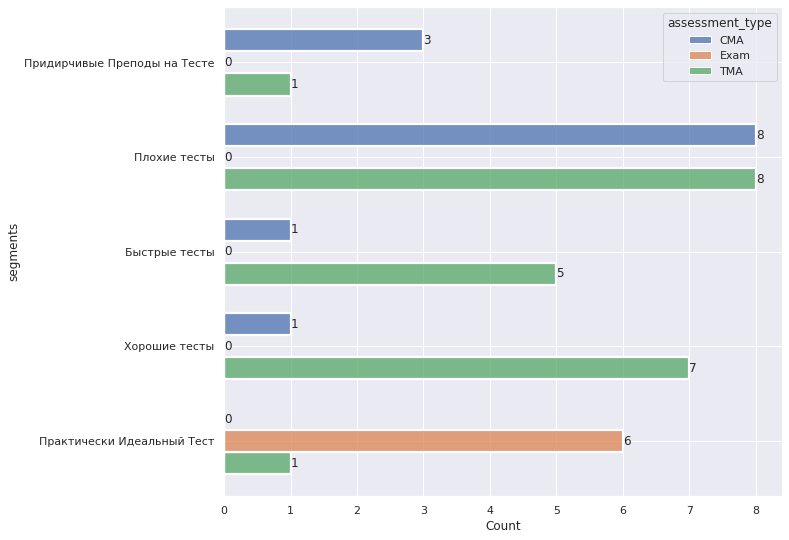

In [92]:
graph_test = sns.histplot(data=rfm_full, y="segments", binwidth= 10, hue = 'assessment_type', 
                     multiple="dodge", shrink=.7)

for container in graph_test.containers:
    graph_test.bar_label(container)

### Интерпретация:
Мы можем увидеть некоторую закономерность между типом теста и сегментами:
 - CMA имеет большую частоту как Плохой тест. Может компьютерные тесты не очень хорошая идея))
 - Экзамены это практически идеальные тесты! Это хорошо: они долго держат студентов, их завершаемость и оценки хорошие!
 - TMA имеет неоднозначную картину. Как и любые другие очные тесты)


#### Предмет

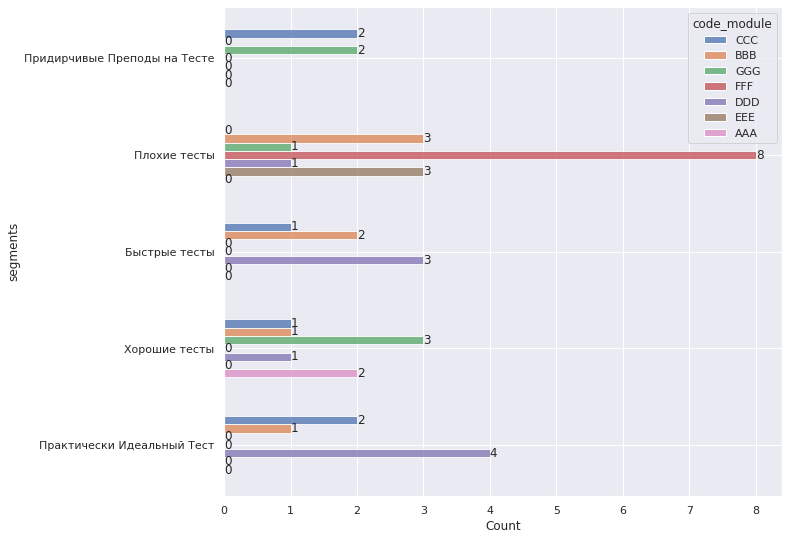

In [93]:
graph = sns.histplot(data=rfm_full, y="segments", binwidth= 10, hue = 'code_module', 
                     multiple="dodge", shrink=.6)

for container in graph.containers:
    graph.bar_label(container)

### Интерпретация:
1. На предмете EEE все тесты плохие)) Это может о чем-то говорить


2. Предмет DDD предполагал экзамен, поэтому много практически идеальных тестов
(Также этот предмет включал в себя много быстрых тестов. Скорее всего, это тренировочные тесты перед экзаменом)

 
3. Предмет AAA имеет хорошие тесты!


4. По предметам: ССС, GGG, BBB неоднозначная картина. Нельзя вывести одну общую интерпретацию по ним



5. На предмете FFF много плохих тестов. Может стоит убрать большое кол-во тренировочных тестов (из первого задания помню, что на этом предмете было много тренировочных тестов). 

#### Семестр

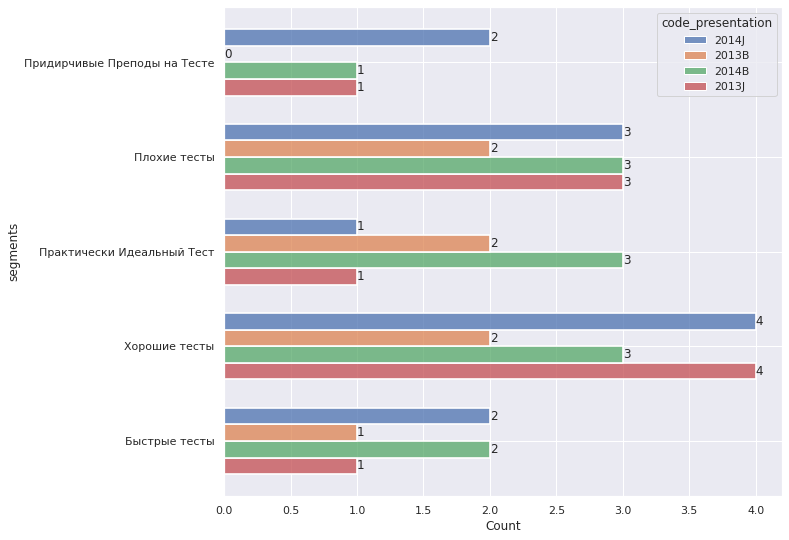

In [77]:
graph_test = sns.histplot(data=rfm_full, y="segments", binwidth= 10, hue = 'code_presentation', 
                     multiple="dodge", shrink=.7)

for container in graph_test.containers:
    graph_test.bar_label(container)

### Интерпретация:

По семестрам явной закономерности нет. Встречаемость сегментов для каждого семестра распределилась более чем ровненько. 

## Общий ответ на вопрос: 

1. Кластеры были образованы, с помощью терцилей


2. Формула успешного теста: 
    - high recency (3) – высокий средний срок сдачи с начала семестра (долгое удержание студента)
    - high frequenct (3) – высокая завершаемость
    - high monetary (3) – высокий балл за тест 
    
    
3. Границы терцилей:  
    
    Recency – средний срок
    - низкая (1): от 84 до 102 дней 
    - средняя (2): от 102 до 127 дней 
    - высокая (3): от 127  до 244 дней
    
    Frequency – завершаемость 
    - низкая (1): от 84 до 94%  
    - средняя (2): от 94 до 98%  
    - высокая (3): от 98  до 100% 

    Monetary – средний баалл 
    - низкая (1): от 62 до 74 баллов  
    - средняя (2): от 74 до 80 баллов  
    - высокая (3): от 80 до 89 баллов  
    
    
4. Было выделено 5 сегментов, исходя из комбинаций RFM:   

"Практически Идеал": 
   - R: тесты средне / долго держали студентов
   - F: у них средняя / хорошая завершаемость
   - M: средние / высокие оценки


"Хорошие": 
   - R: тесты средне / долго держали студентов
   - F: у них средняя / хорошая завершаемость
   - M: средние / высокие оценки
       

"Плохо": 
   - R: тесты не долго держали студентов (короткий / средний период с начала семестра)
   - F: у них низкая / средняя завершаемость
   - M: низкие / средние оценки

"Придирчивые преподы":
  - R: тесты средне / долго держали студентов
  - F: у них средняя / хорошая завершаемость
  - M: низкие оценки
      
      
"Быстрые тесты":
  - R: тесты не долго держали студентов (короткий период с начала семестра)
  - F: у них средняя / хорошая завершаемость
  - M: средние / высокие оценки
  
5. Были выявлены закономерности между сегментами и типом тестов: 
 - CMA имеет высокую частоту как Плохой тест
 - Экзамены это практически идеальные тесты + быстрые тесты (тренировочные, возможно)
 - TMA имеет неоднозначную картину
 
 
6. Были выявлены закономерности между сегментами и предметом: 
    - На предмете EEE все тесты плохие
    - Предмет DDD предполагал экзамен, поэтому много практически идеальных тестов. Также этот предмет включал в себя много быстрых тестов. 
    - Предмет AAA имеет хорошие тесты
    - По предметам: ССС, GGG, BBB неоднозначная картина. 
    - На предмете FFF много плохих тестов. 
    
 
7. Закономерность между сегментами и семестрами не была выявлена
